In [1]:
from containers.cities import CitiesGraph

path = "data/cities.csv"
graph = CitiesGraph.from_file(path, [
    "Dallas",
    "Detroit",
    "Los Angeles",
    "Miami",
    "New York City",
    "Oklahoma City",
    "San Francisco",
])
graph.coords

,city,x,y
0,San Francisco,-2440.234574,-4226.610264
1,Los Angeles,-2609.408837,-4519.628684
2,Oklahoma City,-906.238179,-5139.532107
3,Dallas,-454.849931,-5198.958497
4,Detroit,425.360913,-4861.897489
5,Miami,1002.659670,-5686.365557
6,New York City,1263.158364,-4714.171194


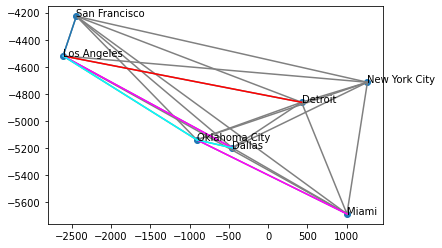

In [2]:
graph.fully_connect()
graph.plot_points()
graph.plot_connections(color="grey")
graph.plot_segment(1, 4, color='r')
graph.plot_segment("Los Angeles", "San Francisco")
graph.plot_segments([(1, 3), (2, 5)], color='magenta')
graph.plot_line([1, 2, 3], color='cyan')